In [37]:
from __future__ import division
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import GPyOpt
from torch.autograd import Variable
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [65]:
def normalize(data, norm_type):
    if norm_type == "minmax":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].min()) / (data[:,i].max()-data[:,i].min())
        return data
    elif norm_type == "zscore":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].mean()) / (data[:,i].std())
        return data
    elif norm_type == None:
        return data
    else:
        raise ValueError("Please choose a correct normalization type")
#Xnumtrain = torch.tensor(np.vstack([(Xnumtrain[:,i]-Xnumtrain[:,i].min()) / (Xnumtrain[:,i].max()-Xnumtrain[:,i].min()) for i in range(Xnumtrain.size()[1]) if "Tue elsker det her"])).view(-1,2)

def dataprep(data, norm_type = "zscore"):
    for category in categoricals:
        data[category] = data[category].astype("category")

    catdata = []
    for i in range(len(categoricals)):
        catdata.append(data[categoricals[i]].cat.codes.values)
    catdata = torch.tensor(catdata, dtype = torch.int64).T
    
    
    numdata = np.stack([data[col].values for col in numericals], 1)
    numdata = torch.tensor(numdata, dtype=torch.float)

    normalize(numdata, norm_type)
    return catdata, numdata

def permutation(data, cat):
    perm_data = data.copy()
    rand_num = np.random.randint(0 , len(data[cat]) , len(data[cat]))
    perm_data[cat][np.arange(len(data[cat]))] = data[cat][rand_num] 
    df = perm_data
    return df

def reset_data():
    return pd.read_csv("https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv")

# Data Visualization and Pre-processing

In [39]:
url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/adult_dataset/Adult.csv"
data = pd.read_csv(url, sep = ";")
data = data[(data["Race"] == " Black") | (data["Race"] == " White")]
data = data.dropna()

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
#print(data.columns)

No GPU available.


In [40]:
print(data.columns)
def is_plot():
    bins = 100
    plt.hist(data["Sex"], bins = bins)
    plt.show()
    plt.hist(data["Race"], bins = bins)
    plt.show()
    plt.hist(data["Salary"], bins = bins)
    plt.show()
    plt.hist(data["Fnlwgt"], bins = bins)
    plt.show()
    plt.hist(data["Capital_gain"], bins = bins)
    plt.show()
    plt.hist(data["Capital_loss"], bins = bins)
    plt.show()
    plt.hist(data["Unknown"], bins = bins)
    plt.show()
    plt.hist(data["Age"], bins = bins)
    plt.show()
#is_plot()

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Unknown', 'Marital_status',
       'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_gain',
       'Capital_loss', 'Hours_per_week', 'Native_country', 'Salary'],
      dtype='object')


In [108]:
categoricals = ["Workclass", "Marital_status", "Relationship", "Race", "Sex", "Native_country", "Occupation", "Education"]
numericals = ["Fnlwgt", "Unknown", "Capital_gain", "Capital_loss", "Hours_per_week"]
features = categoricals + numericals
outputs = ["Salary"]
data = data[features + outputs]
print(data.nunique())

# Making the output binary
data[outputs] = data[outputs].replace({"<=50K":0, ">50K":1}, regex = True)
data[outputs] = data[outputs].astype("category")

Workclass             9
Marital_status        7
Relationship          6
Race                  2
Sex                   2
Native_country       41
Occupation           15
Education            16
Fnlwgt            20674
Unknown              16
Capital_gain        119
Capital_loss         89
Hours_per_week       94
Salary                2
dtype: int64


TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [129]:
Xcat, Xnum = dataprep(data, norm_type = "zscore")

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = y[totalnumber - testnumber:totalnumber]


# Make sure that we dont validate on training data to compare if the algorithm is biased


normalize(Xnumtrain, "zscore");
normalize(Xnumtest, "zscore");

# Neural Network

In [43]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return nn.functional.sigmoid(x)

# Train model on data

In [33]:
# Define and show the model
model = Model(categorical_embedding_sizes, 5, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True


Model(
  (all_embeddings): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(7, 4)
    (2): Embedding(6, 3)
    (3): Embedding(2, 1)
    (4): Embedding(2, 1)
    (5): Embedding(41, 21)
    (6): Embedding(15, 8)
    (7): Embedding(16, 8)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=56, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine

In [34]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5

In [36]:
# thresholds = np.random.uniform(0,1,size=points)
    
def train_model(hyperparameters, model, epochs = 100, plot = False):
    in_features, out_features = 11, 1
    p = hyperparameters['p']
    hidden_units_1 = hyperparameters['hidden_units_1']
    hidden_units_2 = hyperparameters['hidden_units_2']
    hidden_units_3 = hyperparameters['hidden_units_3']
    hidden_units_4 = hyperparameters['hidden_units_4']
    hidden_units_5 = hyperparameters['hidden_units_5']
    activation_func = hyperparameters['activation_func']
    
    model.layers[0] = torch.nn.Linear(in_features, hidden_units_1) 
    model.layers[1] = activation_func
    model.layers[2] = torch.nn.BatchNorm1d(hidden_units_1)
    model.layers[3] = torch.nn.Dropout(p=p)
    model.layers[4] = torch.nn.Linear(hidden_units_1, hidden_units_2) 
    model.layers[5] = activation_func
    model.layers[6] = torch.nn.BatchNorm1d(hidden_units_2)
    model.layers[7] = torch.nn.Dropout(p=p)
    model.layers[8] = torch.nn.Linear(hidden_units_2, hidden_units_3) 
    model.layers[9] = activation_func
    model.layers[10] = torch.nn.BatchNorm1d(hidden_units_3)
    model.layers[11] = torch.nn.Dropout(p=p)
    model.layers[12] = torch.nn.Linear(hidden_units_3, hidden_units_4) 
    model.layers[13] = activation_func
    model.layers[14] = torch.nn.BatchNorm1d(hidden_units_4)
    model.layers[15] = torch.nn.Dropout(p=p)
    model.layers[16] = torch.nn.Linear(hidden_units_4, hidden_units_5) 
    model.layers[17] = activation_func
    model.layers[18] = torch.nn.BatchNorm1d(hidden_units_5)
    model.layers[19] = torch.nn.Dropout(p=p)
    model.layers[20] = torch.nn.Linear(hidden_units_5, out_features) 
    
    aggregated_losses = []
    
    # Initialize lists for training and validation
    train_iter = []
    train_loss, train_accs = [], []
    valid_iter = []
    valid_loss, valid_accs = [], []

    model.train()
    for i in range(epochs):
        i += 1
        y_pred = model(Xcattrain, Xnumtrain)
        single_loss = loss_function(y_pred, ytrain.float())
        aggregated_losses.append(single_loss)

        #if i % 25 == 1:
            #print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

    #print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


    
    # Plot the loss over epocs
    if plot:
        plt.plot(range(epochs), aggregated_losses)
        plt.ylabel('Loss')
        plt.xlabel('epoch');


    # Predict on the test set
    model.eval()
    with torch.no_grad():
        y_val = model(Xcattest, Xnumtest)
        loss = loss_function(y_val, ytest.float())


    y_val = (y_val > threshold).float()

    
    #print(confusion_matrix(ytest,y_val))
    #print(classification_report(ytest,y_val))
    neural_acc = accuracy_score(ytest, y_val)
    
    return model, float(neural_acc)

# Baysian Optimization

In [23]:
ACTIV = {0: torch.nn.Tanh(),
         1: torch.nn.ReLU(),
         2: torch.nn.ReLU6(),
         3: torch.nn.Sigmoid(),
        }

netsize = 246

## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    hyperparameters = {
        'hidden_units_1': int(np.ceil(param[0]*netsize*0.4)+int(10)),
        'hidden_units_2': int(np.ceil(param[0]*netsize*0.7)+int(10)),
        'hidden_units_3': int(np.ceil(param[0]*netsize)+int(10)),
        'hidden_units_4': int(np.ceil(param[0]*netsize*0.7)+int(10)),
        'hidden_units_5': int(np.ceil(param[0]*netsize*0.4)+int(10)),
        'p': param[1],
        'activation_func': ACTIV[int(param[2])]
    }
    print(hyperparameters)
    trained_model, neural_acc  = train_model(hyperparameters, model)
    print(neural_acc)
    return -neural_acc
    
# define the dictionary for GPyOpt
domain = [{'hidden_units'   : 'var_1', 'type': 'continuous', 'domain': (0 , 1)},
          {'p'              : 'var_2', 'type': 'continuous',  'domain': (0 , 1)},
          {'activation_func': 'var_3', 'type': 'categorical','domain': tuple(np.arange(4))}]


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 100) 


x_best = opt.X[np.argmin(opt.Y)]
print("bedste: ", x_best)
#print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
#    x_best[2])  + ", criterion=" + str(
#    x_best[3]))

[[0.779691   0.33370861 2.        ]]
{'hidden_units_1': 87, 'hidden_units_2': 145, 'hidden_units_3': 202, 'hidden_units_4': 145, 'hidden_units_5': 87, 'p': 0.33370861113902184, 'activation_func': ReLU6()}


KeyboardInterrupt: 

# Baseline

In [69]:
def baseline(data):
    
    if data['Salary'].value_counts()[0] > data['Salary'].value_counts()[1]:
        y_pred = [0] * len(data[outputs])
        y_pred = torch.tensor(y_pred)
    else:
        y_pred = [1] * len(data[outputs])
        y_pred = torch.tensor(y_pred)
    return y_pred

trues = y
y_pred = baseline(data)
conf_baseline = confusion_matrix(y_pred,trues)
print(conf_baseline)
print(conf_baseline / conf_baseline.astype(np.float).sum())
baseline_acc = accuracy_score(y_pred, trues)
print(baseline_acc)
print("Difference between baseline and neural network:", neural_acc - baseline_acc)

RecursionError: maximum recursion depth exceeded in comparison

Exception ignored in: 'pandas._libs.lib.c_is_list_like'
Traceback (most recent call last):
  File "C:\Users\ejer\Anaconda3\lib\abc.py", line 184, in __instancecheck__
    if subclass in cls._abc_cache:
  File "C:\Users\ejer\Anaconda3\lib\_weakrefset.py", line 75, in __contains__
    return wr in self.data
RecursionError: maximum recursion depth exceeded in comparison


[[23436  7504]
 [    0     0]]
[[0.75746606 0.24253394]
 [0.         0.        ]]
0.7574660633484163


NameError: name 'neural_acc' is not defined

# Train the Model

In [47]:
# Define and show the model
model = Model(categorical_embedding_sizes, 5, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True


Model(
  (all_embeddings): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(7, 4)
    (2): Embedding(6, 3)
    (3): Embedding(2, 1)
    (4): Embedding(2, 1)
    (5): Embedding(41, 21)
    (6): Embedding(15, 8)
    (7): Embedding(16, 8)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=56, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine

In [48]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5
epochs = 2000
np.random.seed(42)

epoch:   1 loss: 0.78474271
epoch:  26 loss: 0.68339282
epoch:  51 loss: 0.61615491
epoch:  76 loss: 0.55708355
epoch: 101 loss: 0.49083239
epoch: 126 loss: 0.44441524
epoch: 151 loss: 0.41303912
epoch: 176 loss: 0.40011436
epoch: 201 loss: 0.38778266
epoch: 226 loss: 0.38401154
epoch: 251 loss: 0.38169068
epoch: 276 loss: 0.37595254
epoch: 301 loss: 0.37448761
epoch: 326 loss: 0.37393203
epoch: 351 loss: 0.37007245
epoch: 376 loss: 0.36728582
epoch: 401 loss: 0.36695373
epoch: 426 loss: 0.36689827
epoch: 451 loss: 0.36503664
epoch: 476 loss: 0.36412489
epoch: 501 loss: 0.36202651
epoch: 526 loss: 0.36001876
epoch: 551 loss: 0.36229143
epoch: 576 loss: 0.35681579
epoch: 601 loss: 0.35579678
epoch: 626 loss: 0.36006904
epoch: 651 loss: 0.35934263
epoch: 676 loss: 0.35502383
epoch: 701 loss: 0.36085665
epoch: 726 loss: 0.35475445
epoch: 751 loss: 0.35646933
epoch: 776 loss: 0.35604119
epoch: 801 loss: 0.35604474
epoch: 826 loss: 0.35402960
epoch: 851 loss: 0.35360655
epoch: 876 loss: 0.3

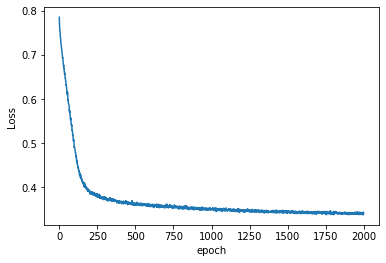

In [49]:
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_pred, ytrain.float())
    aggregated_losses.append(single_loss)

    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')



# Plot the loss over epocs
if "plot":
    plt.plot(range(epochs), aggregated_losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest.float())


y_pred = (y_val > threshold).float()


conf = confusion_matrix(ytest,y_pred)
conf_norm = np.copy(conf).astype(float)
for i in range(2):
    conf_norm[i,:] = conf[i,:] / np.sum(conf, axis = 0)[i]

print(conf)
print(conf_norm)
print(classification_report(ytest,y_pred))
neural_acc = accuracy_score(ytest, y_pred)
print(neural_acc)

# Confusion matrix for black/white

In [51]:
df = data[totalnumber - testnumber:totalnumber]
black_data = df[df["Race"]==" Black"]
white_data = df[df["Race"]==" White"]
Xcat_white, Xnum_white = dataprep(white_data, norm_type = "zscore")
Xcat_black, Xnum_black = dataprep(black_data, norm_type = "zscore")
model.eval()
y_val_white = model(Xcat_white, Xnum_white)
y_pred1 = (y_val_white > threshold).float()
y_val_black = model(Xcat_black, Xnum_black)
y_pred2 = (y_val_black > threshold).float()

# Ground truth of recidivism from dataset
y_white = torch.tensor(white_data["Salary"].values).flatten()
y_black = torch.tensor(black_data["Salary"].values).flatten()

print("Confussion matrix for the white:")
conf_white = confusion_matrix( y_white, y_pred1)
conf_black = confusion_matrix( y_black, y_pred2)

conf_white_norm = np.copy(conf_white).astype(float)
conf_black_norm = np.copy(conf_black).astype(float)
for i in range(2):
    conf_white_norm[i,:] = conf_white[i,:] / np.sum(conf_white, axis = 1)[i]
    conf_black_norm[i,:] = conf_black[i,:] / np.sum(conf_black, axis = 1)[i]

print(conf_white)
print(conf_white_norm)
print()
print("Confussion matrix for the black:")
print(conf_black)
print(conf_black_norm)

#print(conf_white / conf_white.astype(np.float).sum(axis=1))
#print(conf_black / conf_black.astype(np.float).sum(axis=1))
#[0.21548821548821548, 0.3638968481375358] [0.5674157303370787, 0.6658227848101266]
#00 / 00 + 10
#01 / 01 + 00

Confussion matrix for the white:
[[3826  271]
 [ 604  840]]
[[0.93385404 0.06614596]
 [0.41828255 0.58171745]]

Confussion matrix for the black:
[[548  25]
 [ 24  50]]
[[0.95636998 0.04363002]
 [0.32432432 0.67567568]]


* # Fede plots til fremtiden måske:


# Plots of the distribution of black and whites in each category of scoretext
sb.countplot(x = "score_text", data = black_data)
print(len(black_data[black_data["score_text"] == 0]))
print(len(black_data[black_data["score_text"] == 1]))
plt.show()
sb.countplot(x = "score_text", data = white_data)
print(len(white_data[white_data["score_text"] == 0]))
print(len(white_data[white_data["score_text"] == 1]))
plt.show()

# Neural Network Bias Correction

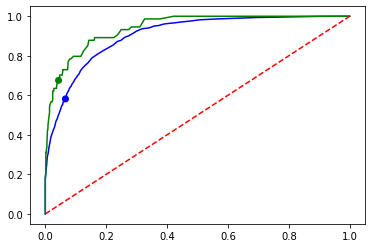

0.5 0.6 0.8862672442913262


In [55]:
def BiasCorrection(points, probs1, probs2, true1, true2, min_threshold = 0.2, max_threshold = 0.8, max_diff = 0.001, show_scatter = True, show_plot = True):
    points = points
    step = 1/points
    thresholds = np.arange(0,1+step,step)

    if show_scatter:
        y_pred1 = (probs1 > 0.5).float()
        y_pred2 = (probs2 > 0.5).float()
        conf1 = confusion_matrix(true1, y_pred1)
        conf2 = confusion_matrix(true2, y_pred2)

        yvals = []
        xvals = []
        yvals.append(conf1[1,1] / (conf1[1,1] + conf1[1,0]))
        xvals.append(conf1[0,1] / (conf1[0,1] + conf1[0,0]))
        yvals.append(conf2[1,1] / (conf2[1,1] + conf2[1,0]))
        xvals.append(conf2[0,1] / (conf2[0,1] + conf2[0,0]))
        plt.scatter(xvals, yvals, c=["blue", "green"])

    tprs1 = []
    fprs1 = []
    tprs2 = []
    fprs2 = []
    for i in range(points+1):
        y_pred1 = (probs1 > thresholds[i]).float()
        y_pred2 = (probs2 > thresholds[i]).float()
        conf1 = confusion_matrix(true1, y_pred1)
        conf2 = confusion_matrix(true2, y_pred2)

        tprs1.append(conf1[1,1] / (conf1[1,1] + conf1[1,0]))
        fprs1.append(conf1[0,1] / (conf1[0,1] + conf1[0,0]))
        tprs2.append(conf2[1,1] / (conf2[1,1] + conf2[1,0]))
        fprs2.append(conf2[0,1] / (conf2[0,1] + conf2[0,0]))

    if show_plot:
        plt.plot(fprs1,tprs1,color="blue")
        plt.plot(fprs2,tprs2,color="green")
        point1 = [0,0]
        point2 = [1,1]
        x_values = [point1[0], point2[0]] 
        y_values = [point1[1], point2[1]]
        plt.plot(x_values, y_values,'--',color="red")
        plt.show()

    # Find the thresholds with the same tpr and fpr
    tprdiff = []
    fprdiff = []
    thresholds1 = []
    thresholds2 = []

    for i in range(len(thresholds)):
        tprval1 = tprs1[i]
        fprval1 = fprs1[i]
        threshold1 = thresholds[i]
        tprindex2 = min(range(len(tprs2)), key=lambda x: abs(tprs2[x]-tprval1))
        threshold2 = thresholds[tprindex2]
        tprval2 = tprs2[tprindex2]
        fprval2 = fprs2[tprindex2]
        tprdiff.append(abs(tprval1 - tprval2))
        fprdiff.append(abs(fprval1 - fprval2))
        thresholds1.append(threshold1)
        thresholds2.append(threshold2)
        #print(tprval1, fprval1, threshold1, tprval2, fprval2, threshold2)

    minthreshold = min_threshold
    maxthreshold = max_threshold
    maxdiff = max_diff
    indeces = np.unique(np.append(np.where(np.array(tprdiff) < maxdiff), np.where(np.array(fprdiff) < maxdiff)))
    thresholds1 = [thresholds1[i] for i in indeces if "Tue elsker det"]
    thresholds2 = [thresholds2[i] for i in indeces if "Tue elsker det"]

    # Find the accuracies for all the thresholds with equal fpr and tpr
    accs = []
    for i in range(len(thresholds1)):
        thres1, thres2 = thresholds1[i], thresholds2[i]
        y_val_white = model(Xcat_white, Xnum_white)
        y_pred1 = (y_val_white > thres1).float()
        y_val_black = model(Xcat_black, Xnum_black)
        y_pred2 = (y_val_black > thres2).float()

        # Ground truth of recidivism from dataset
        y_white = torch.tensor(white_data["Salary"].values).flatten()
        y_black = torch.tensor(black_data["Salary"].values).flatten()
        accs.append((accuracy_score(y_black, y_pred2) + accuracy_score(y_white, y_pred1)) / 2)

    maxaccidx = np.argmax(accs)
    optthres1 = thresholds1[maxaccidx]
    optthres2 = thresholds2[maxaccidx]
    print(optthres1, optthres2, max(accs))

BiasCorrection(100, y_val_white, y_val_black, y_white, y_black, show_scatter = True, show_plot = True)

[0.         0.06614596 1.        ] [0.         0.58171745 1.        ]


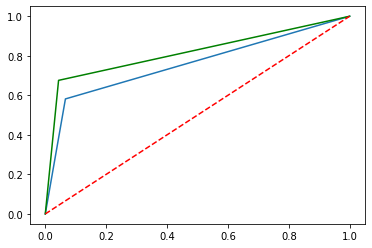

In [57]:
from sklearn import metrics
y_pred1 = (y_val_white > 0.5).float()
y_pred2 = (y_val_black > 0.5).float()
fpr, tpr, thresholds = metrics.roc_curve(y_white, y_pred1.view(-1),pos_label=1)
fpr2, tpr2, thresholds = metrics.roc_curve(y_black, y_pred2.view(-1),pos_label=1)
print(fpr,tpr)
plt.plot(fpr,tpr)
plt.plot(fpr2,tpr2,color="green")
point1 = [0,0]
point2 = [1,1]
x_values = [point1[0], point2[0]] 
y_values = [point1[1], point2[1]]
plt. plot(x_values, y_values,'--',color="red")
plt.show()

# Random Forest

In [126]:
class Classification:
    
    def __init__(self, xtrain, ytrain, classification_model):
        # Classification_model = [GaussianNB(), LogisticRegression(), RandomForestClassifier(n_estimators = 52, max_depth = 14, max_features = "log2", criterion = "entropy")]
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.model = classification_model
        self.model.fit(self.xtrain, self.ytrain)
        
    def Validate(self, model, datatest, ytest, show_acc = True):
        # Predict on the test set
        self.preds = model.predict(datatest)
        self.probs = model.predict_proba(datatest)[:, 1]

        self.acc = len(self.preds[torch.tensor(self.preds, dtype = torch.int64) == ytest]) / len(self.preds)
        self.conf = confusion_matrix(ytest, self.preds)
        self.conf_norm = np.copy(self.conf).astype(float)
        for i in range(2):
            self.conf_norm[i,:] = self.conf[i,:] / np.sum(conf, axis = 1)[i]
        if show_acc:
            print("Accuracy of the model: ", self.acc)
            print(self.conf)
            print(self.conf_norm)
            print()
            
    def FeatureImportance(self, model):
        importances = list(model.feature_importances_)

        # List of tuples with variable and importance
        self.feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]

        # Sort the feature importances by most important first
        self.feature_importances = sorted(self.feature_importances, key = lambda x: x[1], reverse = True)

        # Print out the feature and importances 
        [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in self.feature_importances]


        # List of features sorted from most to least important
        sorted_importances = [importance[1] for importance in self.feature_importances]
        sorted_features = [importance[0] for importance in self.feature_importances]
        # list of x locations for plotting
        x_vals = list(range(len(importances)))
        # Make a bar chart
        plt.bar(x_vals, sorted_importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
        # Tick labels for x axis
        plt.xticks(x_vals, sorted_features, rotation='vertical')
        # Axis labels and title
        plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
        plt.show()


        # Cumulative importances
        cumulative_importances = np.cumsum(sorted_importances)
        # Make a line graph
        plt.plot(x_vals, cumulative_importances, 'g-')
        # Draw line at 95% of importance retained
        plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances)-1, color = 'r', linestyles = 'dashed')
        # Format x ticks and labels
        plt.xticks(x_vals,sorted_features, rotation = 'vertical')
        # Axis labels and title
        plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')
        plt.show()

rf_model = Classification(Xcattrain, ytrain, RandomForestClassifier(n_estimators = 52, max_depth = 14, max_features = "log2", criterion = "entropy"))
rf_model.Validate(rf_model.model, Xcattest, ytest)


# Test for bias
rf_white_test = Classification(Xcattrain, ytrain, RandomForestClassifier())
rf_black_test = Classification(Xcattrain, ytrain, RandomForestClassifier())
rf_white_test.Validate(rf_model.model, Xcat_white, y_white)
rf_black_test.Validate(rf_model.model, Xcat_black, y_black)

Accuracy of the model:  0.8280542986425339
[[4281  389]
 [ 675  843]]
[[0.91670236 0.08329764]
 [0.44466403 0.55533597]]

Accuracy of the model:  0.8198881068399206
[[3726  371]
 [ 627  817]]
[[0.79785867 0.07944325]
 [0.41304348 0.53820817]]

Accuracy of the model:  0.8979907264296755
[[555  18]
 [ 48  26]]
[[0.11884368 0.00385439]
 [0.03162055 0.0171278 ]]



# Random Forest Bias Correction

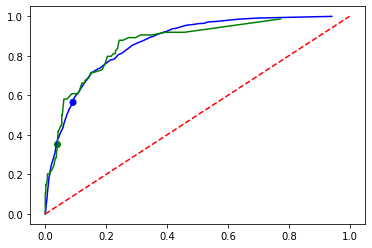

0.6 0.45 0.8793745486435667


In [59]:
BiasCorrection(100, torch.tensor(rf_white_test.probs, dtype = torch.float).reshape(-1, 1), torch.tensor(rf_black_test.probs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)

# Logistic Regression

In [67]:
logreg_model = Classification(Xcattrain, ytrain, LogisticRegression())
logreg_model.Validate(logreg_model.model, Xcattest, ytest)
# Test for bias
lr_white_test = Classification(Xcattrain, ytrain, LogisticRegression())
lr_black_test = Classification(Xcattrain, ytrain, LogisticRegression())
lr_white_test.Validate(logreg_model.model, Xcat_white, y_white)
lr_black_test.Validate(logreg_model.model, Xcat_black, y_black)

Accuracy of the model:  0.7508080155138979
[[4638   32]
 [1510    8]]
[[0.99314775 0.00685225]
 [0.99472991 0.00527009]]

Accuracy of the model:  0.7350658725861757
[[4065   32]
 [1436    8]]
[[0.87044968 0.00685225]
 [0.94598155 0.00527009]]

Accuracy of the model:  0.8856259659969088
[[573   0]
 [ 74   0]]
[[0.12269807 0.        ]
 [0.04874835 0.        ]]



# Bias Correction for Logistic Regression

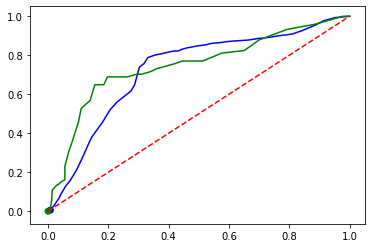

0.48 0.37 0.8762995369351472


In [61]:
BiasCorrection(100, torch.tensor(lr_white_test.probs, dtype = torch.float).reshape(-1, 1), torch.tensor(lr_black_test.probs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)

# Gaussian Naive Bayes

In [68]:
naive_model = Classification(Xcattrain, ytrain, GaussianNB())
naive_model.Validate(naive_model.model, Xcattest, ytest)

# Test for bias
nb_white_test = Classification(Xcattrain, ytrain, GaussianNB())
nb_black_test = Classification(Xcattrain, ytrain, GaussianNB())
nb_white_test.Validate(naive_model.model, Xcat_white, y_white)
nb_black_test.Validate(naive_model.model, Xcat_black, y_black)

Accuracy of the model:  0.7467679379444085
[[3532 1138]
 [ 429 1089]]
[[0.75631692 0.24368308]
 [0.2826087  0.7173913 ]]

Accuracy of the model:  0.7305540516152319
[[2959 1138]
 [ 355 1089]]
[[0.63361884 0.24368308]
 [0.23386034 0.7173913 ]]

Accuracy of the model:  0.8856259659969088
[[573   0]
 [ 74   0]]
[[0.12269807 0.        ]
 [0.04874835 0.        ]]



# Bias Correction for Gaussian Naive Bayes

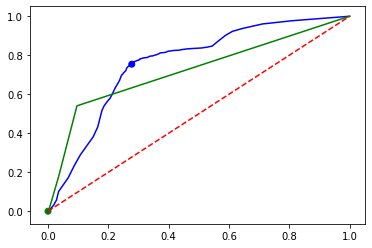

0.86 0.03 0.7040676402158199


In [63]:
BiasCorrection(100, torch.tensor(nb_white_test.probs, dtype = torch.float).reshape(-1, 1), torch.tensor(nb_black_test.probs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)

# Temp Bayesian Optimization

In [107]:
## define the domain of the considered parameters
n_estimators = tuple(np.arange(1,101,1, dtype= np.int))
# print(n_estimators)
max_depth = tuple(np.arange(10,110,10, dtype= np.int))
# max_features = ('log2', 'sqrt', None)
max_features = (0, 1)
# criterion = ('gini', 'entropy')
criterion = (0, 1)


# define the dictionary for GPyOpt
domain = [{'n_estimators': 'var_1',  'type': 'discrete',     'domain': n_estimators},
          {'max_depth': 'var_2',     'type': 'discrete',     'domain': max_depth},
          {'max_features': 'var_3',  'type': 'categorical',  'domain': max_features},
          {'criterion': 'var_4',     'type': 'categorical',  'domain': criterion}]


## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    param = param.astype(int)
    
    if param[2] == 0:
        var_3 = "log2"
    else:
        var_3 = "sqrt"
    
    if param[3] == 0:
        var_4 = "gini"
    else:
        var_4 = "entropy"
    
    #fit the model
    model = RandomForestClassifier(n_estimators = param[0], criterion = var_4, max_depth = param[1], max_features = var_3, oob_score = True)
    model.fit(Xcattrain, ytrain)
    preds = model.predict(Xcattest)
    acc = accuracy_score(ytest, preds)
    
    #model = Classification(Xcattrain, ytrain, RandomForestClassifier(n_estimators = param[0], max_depth = param[1], max_features = var_3, criterion = var_4))
    #model.Validate(rf_model.model, Xcattest, ytest, show_acc = False)
    print(acc)
    return - acc


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=100000000

opt.run_optimization(max_iter = 10000000) 

x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
    x_best[2])  + ", criterion=" + str(
    x_best[3]))

[[74. 30.  1.  1.]]
0.8220749838396897
[[99. 70.  0.  1.]]
0.8228829993535876
[[92. 10.  1.  1.]]
0.8282159017453136
[[34. 70.  1.  1.]]
0.8236910148674854
[[93. 80.  1.  1.]]
0.8236910148674854
[[93. 10.  1.  1.]]
0.8290239172592114
[[98. 10.  1.  1.]]
0.8299935358758889
[[100.  10.   0.   0.]]
0.8296703296703297
[[100.  10.   1.   1.]]
0.8275694893341952
[[100.  10.   0.   0.]]
0.8293471234647706
[[ 1. 10.  0.  0.]]
0.8135100193923723
[[  1. 100.   1.   0.]]
0.807207498383969
[[ 64. 100.   0.   1.]]
0.8219133807369101
[[100.  10.   0.   0.]]
0.829185520361991
[[96. 10.  0.  0.]]
0.8296703296703297
[[97. 20.  0.  1.]]
0.8223981900452488
[[43. 10.  0.  1.]]
0.8290239172592114
[[51. 10.  1.  0.]]
0.8285391079508727
[[46. 20.  1.  0.]]
0.8246606334841629
[[34. 10.  1.  0.]]
0.8293471234647706
[[30. 20.  0.  1.]]
0.820458952811894
[[61. 10.  0.  1.]]
0.8290239172592114
[[70. 10.  1.  0.]]
0.8301551389786684
[[76. 10.  0.  0.]]
0.8293471234647706
[[100. 100.   0.   0.]]
0.8230446024563671


# Random Forest Feature Importance

Variable: Relationship         Importance: 0.26
Variable: Education            Importance: 0.2
Variable: Marital_status       Importance: 0.19
Variable: Occupation           Importance: 0.18
Variable: Workclass            Importance: 0.07
Variable: Sex                  Importance: 0.04
Variable: Native_country       Importance: 0.04
Variable: Race                 Importance: 0.02


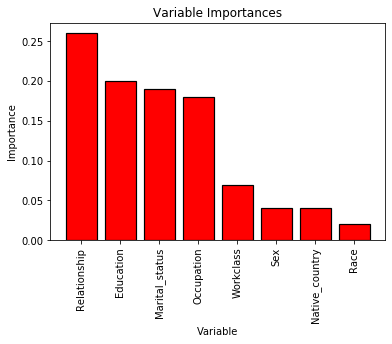

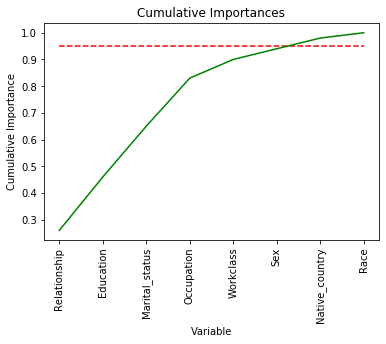

In [127]:
# Get numerical feature importances
rf_model = Classification(Xcattrain, ytrain, RandomForestClassifier(n_estimators = 52, max_depth = 14, max_features = "log2", criterion = "entropy"))
rf_model.FeatureImportance(rf_model.model)